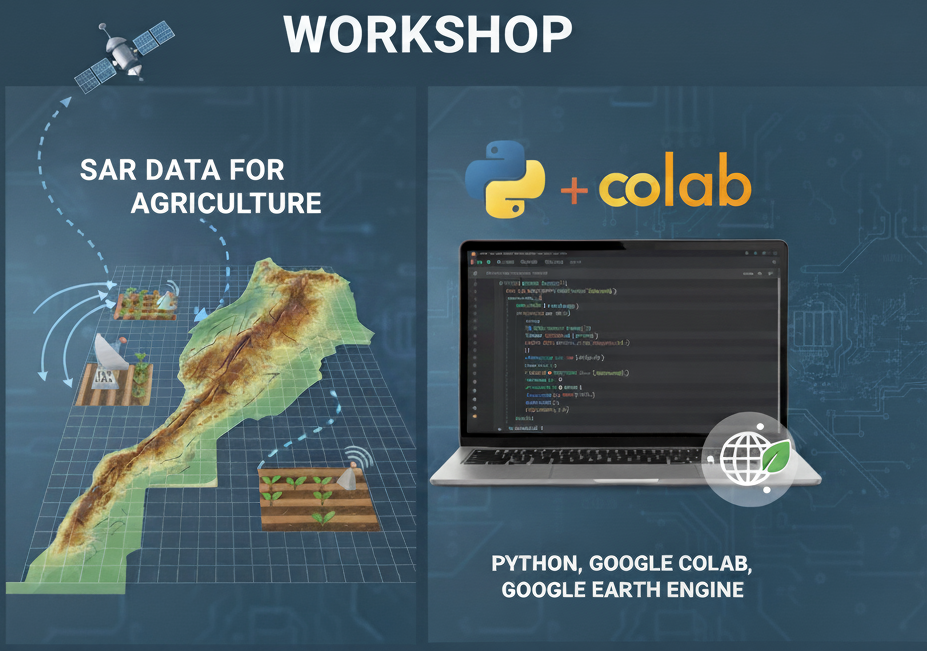

In [ ]:
# @title Time series of NDVI, Precipitation and Soil Moisture
from IPython.display import HTML, display
from google.colab import files
import os
import base64

# List of expected video paths (update if names/subfolders differ)
videos = [
    '/content/ndvi_animation.mp4',
    '/content/precip_animation.mp4',
    '/content/soil_moisture_animation.mp4'
]

# Check and upload if missing
for i, video_path in enumerate(videos):
    if not os.path.exists(video_path):
        print(f"Upload {os.path.basename(video_path)}:")
        uploaded = files.upload()
        if uploaded:
            # Save uploaded file to path
            uploaded_file = list(uploaded.keys())[0]
            os.rename(uploaded_file, video_path)  # Move to expected path
        else:
            print(f"Skipping {video_path} - no upload.")

# Base64 embed with increased size (more reliable, but larger)
html_base64 = '<div style="display: flex; justify-content: space-around;">'
for video_path in videos:
    if os.path.exists(video_path):
        with open(video_path, 'rb') as f:
            video_data = base64.b64encode(f.read()).decode('utf-8')
        html_base64 += f'<video width="400" height="300" autoplay loop muted playsinline><source src="data:video/mp4;base64,{video_data}" type="video/mp4"></video>'
    else:
        html_base64 += f'<p>Video not found: {video_path}</p>'
html_base64 += '</div>'
display(HTML(html_base64))

## **Installing packages**
#### 1.  Installs essential Python packages required for the notebook's functionality.

#### 2.Includes tools for data access (e.g., **earthaccess**), file handling (e.g., **h5py**), visualization (e.g., **matplotlib**, **plotly**), geospatial operations (e.g., **geopandas**, *rasterio*), and progress tracking (e.g., **tqdm**).

In [ ]:
# Install required packages
!pip install earthaccess h5py matplotlib numpy sentinelsat geopandas rasterio scipy
!pip install pystac_client ipyleaflet geopy netCDF4 h5py shapely geopandas rasterio
!pip install plotly
!pip install tqdm

## Import Statements

#### 1. Imports all necessary libraries and modules used throughout the notebook.
#### 2. Covers data access (**earthaccess**, **h5py**), numerical processing (**numpy**, **pandas**), visualization (**matplotlib**, **plotly**), geospatial tools (**geopandas**, **rasterio**, **shapely**), interactive mapping (**ipyleaflet**), and more.
#### 3. Includes tqdm for progress bars and xarray for multidimensional data.

In [ ]:
import earthaccess
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sentinelsat import SentinelAPI, geojson_to_wkt
import geopandas as gpd
import zipfile
import os
import rasterio
from rasterio.plot import show
from scipy.stats import norm  # For potential thresholding
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import requests
import netCDF4 as nc
import h5py
from shapely.geometry import Polygon, mapping
import geopandas as gpd
import rasterio
from rasterio.plot import show
from sentinelsat import SentinelAPI
import xarray as xr
from ipyleaflet import Map, DrawControl, basemaps
from geopy.geocoders import Nominatim
import pystac_client
import getpass
import plotly.express as px
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio.vrt import WarpedVRT
from rasterio.warp import calculate_default_transform
from rasterio.io import MemoryFile
from rasterio.mask import mask
from contextlib import ExitStack
import glob
from tqdm.notebook import tqdm
import ee  # Google Earth Engine
import random  # Added for random selection

## **NASA Earthdata Credentials Setup**

####1. Prompts the user to enter NASA Earthdata username and password securely.
####2. Saves the credentials to a *.netrc* file for authentication with **Earthdata** services.
####3. Sets file permissions to ensure security.

####Please use this url to create an Earthdata account(https://urs.earthdata.nasa.gov/users/new). The account creation and activation takes a few minutes. Please check the spam/junk folder for the verification email, if you didn't receive one while signing in.

####4. After registration, ensure your account is linked to the relevant NASA DAAC (e.g., NSIDC for SMAP data) by logging in and accepting any terms if prompted— this is automatic for most public datasets.
####5. If you don't receive the verification email within 5 minutes, check spam/junk or request a resend via the login page.
####6. For troubleshooting (e.g., login errors), visit: https://urs.earthdata.nasa.gov/documentation/faq.


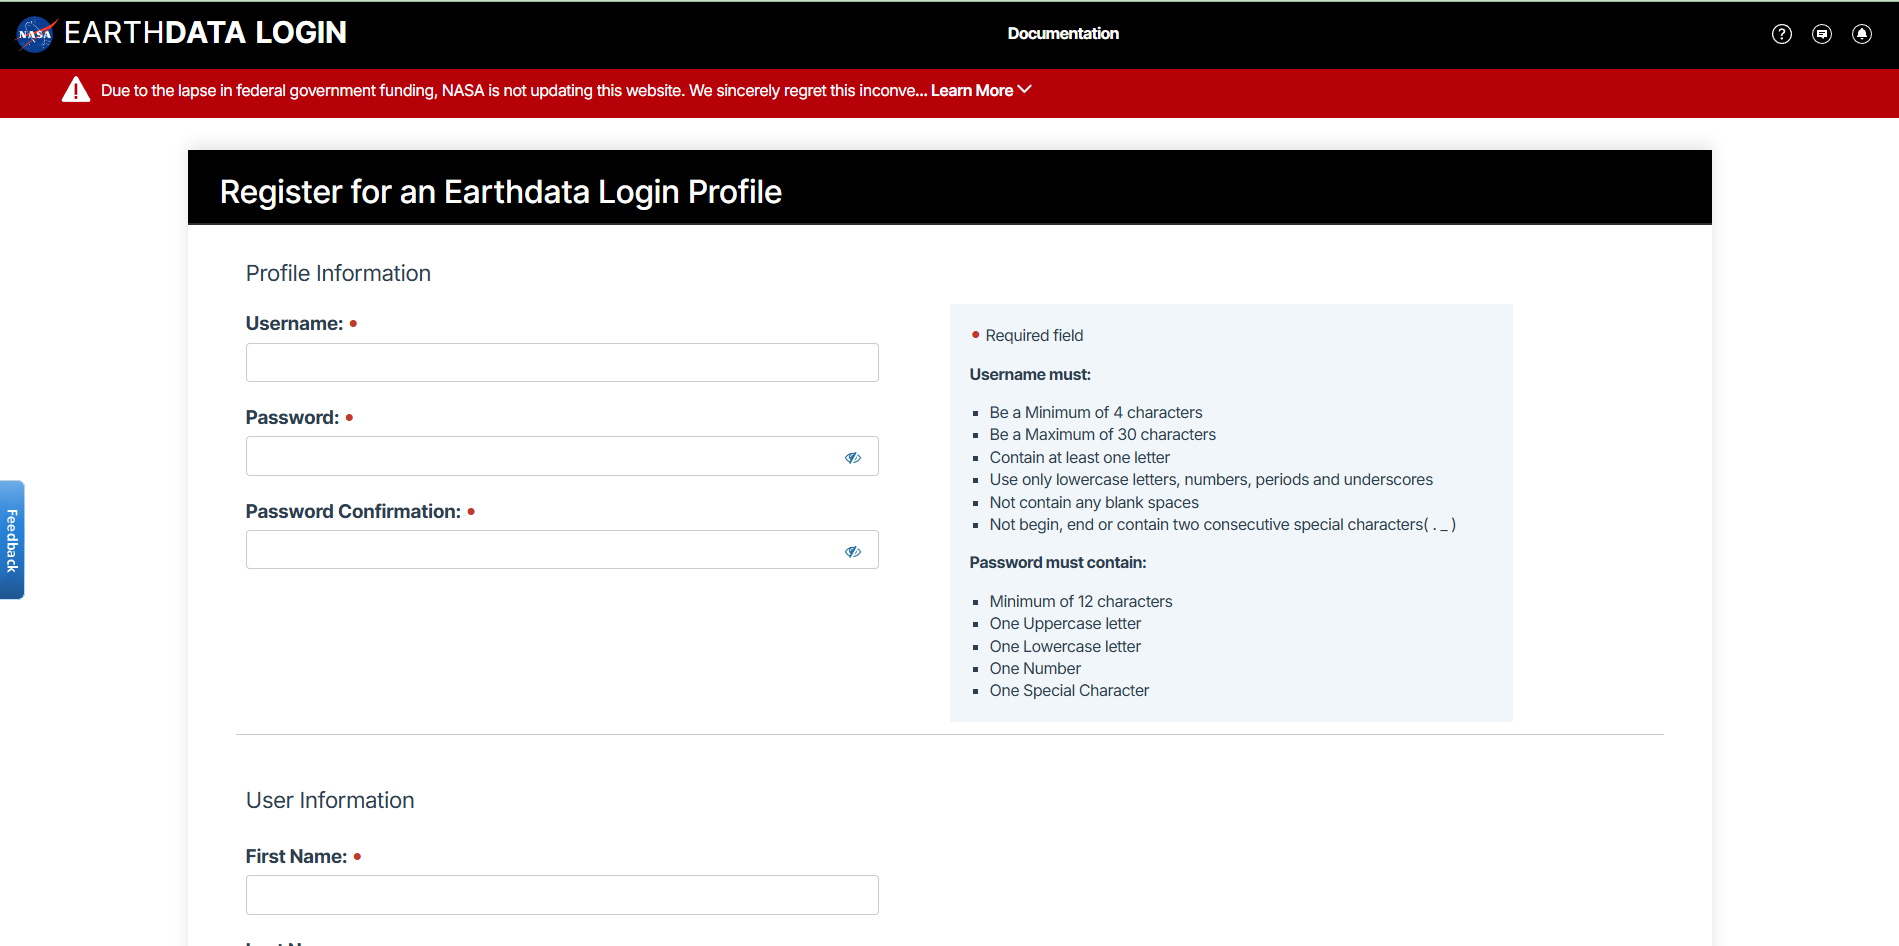

In [ ]:
# Set up NASA Earthdata credentials ()
username = input("Enter your NASA Earthdata Login username: ")
password = getpass.getpass("Enter your NASA Earthdata Login password: ")

# Save credentials to .netrc file for authentication
!echo "machine urs.earthdata.nasa.gov login {username} password {password}" > ~/.netrc
!chmod 0600 ~/.netrc

## Prerequisite: Google Earth Engine (GEE) Access
This notebook fetches precipitation data via GEE, which requires a free account and a Google Cloud Project.

1. Sign up for Earth Engine (if not done): [https://signup.earthengine.google.com](https://signup.earthengine.google.com). Use your Google account; approval is usually instant.
2. Create a Google Cloud Project:
   - Go to [https://console.cloud.google.com](https://console.cloud.google.com).
   - Click "New Project", name it (e.g., "gee-training"), and note the Project ID (e.g., "ee-yourname-12345").
3. Register the project with Earth Engine:
   - In the EE Code Editor ([https://code.earthengine.google.com](https://code.earthengine.google.com)), go to Assets > Register new project.
   - Select your project and confirm.
4. In this notebook, update `ee.Initialize(project='your-project-id')` with your Project ID.
5. Run `ee.Authenticate()`—follow the popup to authorize (do this once per Colab session).

For details, see: [https://developers.google.com/earth-engine/guides/python_install-colab](https://developers.google.com/earth-engine/guides/python_install-colab) or [https://developers.google.com/earth-engine/guides/transition_to_cloud_projects](https://developers.google.com/earth-engine/guides/transition_to_cloud_projects).

6. After creating the project, enable the Earth Engine API:
  - Go to https://console.cloud.google.com/apis/library/earthengine.googleapis.com.
  - Search for "Earth Engine API," select it, and click "Enable." This takes seconds.
- If your Google account is managed by an organization (e.g., work/school), you may need admin approval to create projects or enable APIs—use a personal Gmail account as a fallback.
- During ee.Authenticate(), a popup will ask for permissions; grant "View and manage your Earth Engine data" and any others shown.
- If you get errors like "API not enabled" or "project not registered," double-check the API is enabled and the project is registered in the EE Code Editor (https://code.earthengine.google.com > Settings > Cloud projects).
- For quota limits (rare for this notebook), request increases via https://code.earthengine.google.com > Settings > Quotas.
- Full guide with screenshots: https://developers.google.com/earth-engine/guides/python_install-colab.

## **Mount Google Drive**

####1. Mounts the user's Google Drive to the Colab environment for persistent storage.
####2. Defines and creates output directories for SMAP/S1 data, Sentinel-1 data.
####3. Ensures directories exist to store downloaded and processed files.

In [ ]:
# --- Code to mount Google Drive ---
from google.colab import drive
import os
import shutil

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Define target directories in Google Drive
smap_output_dir = '/content/drive/MyDrive/smap_s1_data'
sentinel_output_dir = '/content/drive/MyDrive/sentinel1_rtc_data'
gee_exports_dir = '/content/drive/MyDrive/GEE_Exports'  # Assuming this folder exists with Croplands_Binary_WGS84.tif

# Create directories if they don't exist
for dir_path in [smap_output_dir, sentinel_output_dir, gee_exports_dir]:
    if not os.path.exists(dir_path):
        print(f"Creating directory: {dir_path}")
        os.makedirs(dir_path)

## **Interactive Map for SMAP/S1 Region of Interest**

####1. Creates an interactive map centered on an agricultural region in Morocco using ipyleaflet.
####2. Allows the user to draw a rectangular region of interest (ROI) for SMAP/S1 data selection.
####3. Captures and stores the drawn ROI coordinates for bounding box conversion.

In [ ]:
# Create a map for drawing the region of interest for SMAP/S1
# Centering the map on an agricultural region in Morocco (e.g., Souss-Massa)
m_smap = Map(center=(30.16, -9.25), zoom=12, basemap=basemaps.Esri.WorldImagery)
draw_control_smap = DrawControl()
draw_control_smap.rectangle = {
    "shapeOptions": {
        "color": "#ff0000",
        "fill_color": "#ff0000",
        "opacity": 1.0,
        "fill_opacity": 0.2,
    }
}
m_smap.add_control(draw_control_smap)

# Container for the drawn rectangle
user_roi_smap = {}

def handle_draw_smap(self, action, geo_json):
    global user_roi_smap
    user_roi_smap = {
        "type": geo_json['geometry']['type'],
        "coordinates": geo_json['geometry']['coordinates']
    }
    print(f"Selected SMAP/S1 ROI: {user_roi_smap}")

draw_control_smap.on_draw(handle_draw_smap)
m_smap

## **Download SMAP/S1 Data**

####1. Defines a function to download SMAP/S1 data from NSIDC using earthaccess, with support for bounding box and date range.
####2. Converts the user-drawn ROI to a bounding box and prompts for date inputs.
####3. Searches and downloads data granules with a progress bar enabled for tracking download progress.

In [ ]:
# Function to download SMAP data
def download_smap_data(product_id, start_date, end_date, bbox, output_dir='smap_data'):
    """
    Download SMAP data from NSIDC using earthaccess

    Parameters:
    -----------
    product_id : str
        SMAP product ID, e.g., 'SPL2SMAP_S' for SMAP/Sentinel-1 data product
    start_date : str
        Start date in format 'YYYY-MM-DD'
    end_date : str
        End date in format 'YYYY-MM-DD'
    bbox : list
        Bounding box [west, south, east, north]
    output_dir : str
        Directory to save downloaded data
    """
    import os
    import earthaccess

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Use earthaccess to search and download data
    try:
        # Authenticate with Earthdata using .netrc credentials (no interactive fallback)
        auth = earthaccess.login(strategy='netrc')
        if not auth:
            print("Earthdata authentication failed. Please check your .netrc credentials.")
            return

        print(f"Searching for {product_id} data from {start_date} to {end_date} in bbox {bbox}...")
        search_results = earthaccess.search_data(
            short_name=product_id,
            temporal=(start_date, end_date),
            bounding_box=(bbox[0], bbox[1], bbox[2], bbox[3])
        )

        if search_results:
            print(f"Found {len(search_results)} granules. Downloading...")
            earthaccess.download(search_results, local_path=output_dir, show_progress=True)
            print("Download complete.")
            print(f"Data has been downloaded to: {output_dir}")
        else:
            print("No data found for the specified criteria.")

    except Exception as e:
        print(f"An error occurred during data access: {e}")

# Convert user_roi to bounding box format [west, south, east, north]
def roi_to_bbox(roi):
    coords = roi['coordinates'][0]
    lons = [coord[0] for coord in coords]
    lats = [coord[1] for coord in coords]
    return [min(lons), min(lats), max(lons), max(lats)]

# Check for ROI and prompt/download only if it exists
try:
    if user_roi_smap:
        product_id = "SPL2SMAP_S"  # SMAP/Sentinel-1 1km soil moisture product
        start_date = input("Enter start date (YYYY-MM-DD): ")
        end_date = input("Enter end date (YYYY-MM-DD): ")
        bbox_smap = roi_to_bbox(user_roi_smap)
        download_smap_data(product_id, start_date, end_date, bbox_smap, output_dir=smap_output_dir)
    else:
        print("Please draw a region of interest on the SMAP/S1 map before proceeding.")
except NameError:
    print("Please run the previous cell to draw the ROI first.")

##**Count and Explore SMAP/S1 Files**

####1. Counts the number of downloaded .h5 files in the SMAP output directory.
####2. Explores the structure of the first .h5 file by listing groups and datasets recursively.
####3. Prints keys, shapes, and data types for understanding the data format.

In [ ]:
# Count the number of .h5 files (case-insensitive)
h5_file_count = 0
if os.path.exists(smap_output_dir):
    for filename in os.listdir(smap_output_dir):
        if filename.lower().endswith('.h5'):
            h5_file_count += 1
    print(f"Number of .h5 files in {smap_output_dir}: {h5_file_count}")
else:
    print(f"Directory not found: {smap_output_dir}")

# List all .h5 files in the directory
h5_files = [f for f in os.listdir(smap_output_dir) if f.lower().endswith('.h5')]

if not h5_files:
    print("No .h5 files found in the directory.")
else:
    # Select the first .h5 file
    selected_file = h5_files[0]
    file_path = os.path.join(smap_output_dir, selected_file)

    # Open the HDF5 file
    with h5py.File(file_path, 'r') as hdf:
        print(f"Keys/Variables in {selected_file}:")
        # Recursively list all keys
        def print_keys(group, prefix=''):
            for key in group.keys():
                item = group[key]
                if isinstance(item, h5py.Group):
                    print(f"{prefix}Group: {key}")
                    print_keys(item, prefix + '  ')
                elif isinstance(item, h5py.Dataset):
                    print(f"{prefix}Dataset: {key} (shape: {item.shape}, dtype: {item.dtype})")

        print_keys(hdf)

##**SMAP/S1 Time Series Analysis**

####1. Identifies an agricultural point in the data grid based on landcover classes.
####2. Extracts time series data (brightness temperature, backscatter, soil moisture) from all .h5 files at the selected point.
####3. Creates a DataFrame, handles missing values, and plots interactive time series charts using Plotly.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import h5py
import plotly.express as px
import random
import ee
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Authenticate and initialize Earth Engine
# This will prompt for authentication if not already done
ee.Authenticate()
ee.Initialize(project='ee-enter-your-project-id')

# Function to find a random agricultural grid point (IGBP class 12 or 14) with valid data
def find_agricultural_point(hdf):
    landcover = hdf['Soil_Moisture_Retrieval_Data_1km/landcover_class_1km'][:]
    soil_moisture = hdf['Soil_Moisture_Retrieval_Data_1km/soil_moisture_1km'][:]
    fill_value = -9999.0

    # Mask for agricultural classes and valid soil moisture
    ag_mask = np.isin(landcover, [12, 14]) & (soil_moisture > 0) & (soil_moisture != fill_value)

    if np.any(ag_mask):
        # Find indices of valid ag points
        valid_indices = np.argwhere(ag_mask)
        # Pick a random one
        random_idx = random.choice(valid_indices)
        return tuple(random_idx)
    else:
        print("No agricultural points with valid data found. Falling back to grid center.")
        return np.array(landcover.shape) // 2  # Default to center if no ag points

# Collect data from all .h5 files
data_list = []
h5_files = sorted([f for f in os.listdir(smap_output_dir) if f.lower().endswith('.h5')])  # Sort for chronological order

# Find suitable index from the first file
if h5_files:
    first_file_path = os.path.join(smap_output_dir, h5_files[0])
    with h5py.File(first_file_path, 'r') as hdf:
        idx = find_agricultural_point(hdf)
        lat = float(hdf['Soil_Moisture_Retrieval_Data_1km/latitude_1km'][idx])
        lon = float(hdf['Soil_Moisture_Retrieval_Data_1km/longitude_1km'][idx])
        print(f"Selected random point for SMAP/S1: Lat {lat:.4f}, Lon {lon:.4f} (grid index {idx})")
else:
    print("No .h5 files found.")
    idx = (0, 0)  # Fallback

fill_value = -9999.0

for filename in h5_files:
    file_path = os.path.join(smap_output_dir, filename)
    with h5py.File(file_path, 'r') as hdf:
        group = 'Soil_Moisture_Retrieval_Data_1km'

        # Extract variables
        tb_v = hdf[f'{group}/tb_v_disaggregated_1km'][idx]
        sigma_vv = hdf[f'{group}/sigma0_vv_aggregated_1km'][idx]
        sigma_vh = hdf[f'{group}/sigma0_vh_aggregated_1km'][idx]
        soil_moisture = hdf[f'{group}/soil_moisture_1km'][idx]

        # Extract overpass time (seconds since J2000 epoch: 2000-01-01 12:00:00 UTC)
        overpass_sec = hdf[f'{group}/spacecraft_overpass_time_seconds_1km'][idx]
        if overpass_sec == fill_value:
            continue  # Skip invalid entries
        overpass_sec = float(overpass_sec)
        epoch = datetime.datetime(2000, 1, 1, 12, 0, 0)
        date = epoch + datetime.timedelta(seconds=overpass_sec)

        # Compute RVI if valid VV and VH
        if not np.isnan(sigma_vv) and not np.isnan(sigma_vh) and (sigma_vv + sigma_vh) != 0:
            rvi = 4 * sigma_vh / (sigma_vv + sigma_vh)
        else:
            rvi = np.nan

        data_list.append({
            'date': date,
            'tb_v': tb_v if tb_v != fill_value else np.nan,  # Brightness temp V-pol (K)
            'sigma_vv': sigma_vv if sigma_vv != fill_value else np.nan,  # VV backscatter (linear)
            'sigma_vh': sigma_vh if sigma_vh != fill_value else np.nan,  # VH backscatter (linear)
            'soil_moisture': soil_moisture if soil_moisture != fill_value else np.nan,  # Soil moisture (m³/m³)
            'rvi': rvi  # Radar Vegetation Index (unitless)
        })

# Create DataFrame, drop rows with NaN in any column
df_smap = pd.DataFrame(data_list).dropna()
if not df_smap.empty:
    # Normalize 'date' to calendar date only (start of day) to group by date regardless of time
    df_smap['date'] = df_smap['date'].dt.normalize()
    df_smap = df_smap.groupby('date').mean().reset_index()

# Fetch precipitation data using Earth Engine (CHIRPS daily)
df_precip = pd.DataFrame()
if not df_smap.empty:
    try:
        point = ee.Geometry.Point(lon, lat)
        start_date_ee = ee.Date(df_smap['date'].min())
        end_date_ee = ee.Date(df_smap['date'].max()).advance(1, 'day')
        chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
            .filterDate(start_date_ee, end_date_ee) \
            .select('precipitation')
        time_series_precip = chirps.getRegion(point, scale=5000).getInfo()
        if len(time_series_precip) > 1:
            columns_p = time_series_precip[0]
            data_p = time_series_precip[1:]
            df_precip = pd.DataFrame(data_p, columns=columns_p)
            df_precip['date'] = pd.to_datetime(df_precip['time'], unit='ms')
            df_precip = df_precip.set_index('date')
            df_precip = df_precip[['precipitation']]
            df_precip = df_precip.apply(pd.to_numeric, errors='coerce')
            df_precip = df_precip.dropna().reset_index()
            # Normalize date to start of day for consistency
            df_precip['date'] = df_precip['date'].dt.normalize()
            df_precip = df_precip.groupby('date').mean().reset_index()
    except Exception as e:
        print(f"Failed to fetch precipitation data: {e}")

# Plot separate time series with Plotly for hover interactivity
# Brightness Temperature (V-pol)
if not df_smap.empty and 'tb_v' in df_smap.columns:
    fig_tb = px.line(df_smap, x='date', y='tb_v', title='Brightness Temperature (V-pol) Time Series',
                     labels={'tb_v': 'Brightness Temperature (K)', 'date': 'Date'})
    fig_tb.update_traces(mode='lines+markers')
    fig_tb.show()
else:
    print("No valid brightness temperature data to plot.")

# VV Backscatter
if not df_smap.empty and 'sigma_vv' in df_smap.columns:
    fig_vv = px.line(df_smap, x='date', y='sigma_vv', title='VV Backscatter Time Series (linear)',
                     labels={'sigma_vv': 'VV Backscatter (linear)', 'date': 'Date'})
    fig_vv.update_traces(mode='lines+markers')
    fig_vv.show()
else:
    print("No valid VV backscatter data to plot.")

# VH Backscatter
if not df_smap.empty and 'sigma_vh' in df_smap.columns:
    fig_vh = px.line(df_smap, x='date', y='sigma_vh', title='VH Backscatter Time Series (linear)',
                     labels={'sigma_vh': 'VH Backscatter (linear)', 'date': 'Date'})
    fig_vh.update_traces(mode='lines+markers')
    fig_vh.show()
else:
    print("No valid VH backscatter data to plot.")

# Radar Vegetation Index (RVI)
if not df_smap.empty and 'rvi' in df_smap.columns:
    fig_rvi = px.line(df_smap, x='date', y='rvi', title='Radar Vegetation Index (RVI) Time Series',
                     labels={'rvi': 'RVI (unitless)', 'date': 'Date'})
    fig_rvi.update_traces(mode='lines+markers')
    fig_rvi.show()
else:
    print("No valid RVI data to plot.")

# Combined Soil Moisture and Precipitation Plot
if not df_smap.empty and 'soil_moisture' in df_smap.columns:
    fig_combined = make_subplots(specs=[[{"secondary_y": True}]])

    # Soil Moisture (primary y-axis, blue)
    fig_combined.add_trace(
        go.Scatter(x=df_smap['date'], y=df_smap['soil_moisture'], name='Soil Moisture (m³/m³)', mode='lines+markers', line=dict(color='blue')),
        secondary_y=False,
    )
    fig_combined.update_yaxes(title_text='Soil Moisture (m³/m³)', secondary_y=False)

    # Precipitation if available (secondary y-axis, inverted, orange bar plot)
    if not df_precip.empty and 'precipitation' in df_precip.columns:
        fig_combined.add_trace(
            go.Bar(x=df_precip['date'], y=df_precip['precipitation'], name='Precipitation (mm)', marker_color='orange'),
            secondary_y=True,
        )
        fig_combined.update_yaxes(title_text='Precipitation (mm)', secondary_y=True, autorange='reversed')

    fig_combined.update_layout(title='Soil Moisture and Precipitation Time Series')
    fig_combined.show()
else:
    print("No valid soil moisture data to plot.")

## **Spatial representation of SMAP/S1 data and it's variables**

####1. Fetch all the variables within the defined bounding box and ensure that all of them have a consistent dimension.
####2. The land cover map was used to mask out only cropland areas in the bounding box to compute all variables spatially.
####3. Please note that SMAP/S1 variables are in EASE-Grid v2.0 projection system which is different than the Geographical coordinate system. So for overlaying on basemap, you need to reproject the data first.

In [ ]:
import os
import numpy as np
import datetime
import h5py
import random
import ee
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Authenticate and initialize Earth Engine if not done
# ee.Authenticate()
# ee.Initialize()

# Function to convert ROI to bbox (if not defined earlier)
def roi_to_bbox(roi):
    if roi and roi['type'] == 'Polygon':
        coords = roi['coordinates'][0]
        lons = [c[0] for c in coords]
        lats = [c[1] for c in coords]
        return [min(lons), min(lats), max(lons), max(lats)]
    return None

# Assume smap_output_dir is defined from previous code, e.g., '/content/smap_data'
# Use user_roi_smap from the SMAP draw control; fallback to Morocco bbox [-12, 28, -1, 36]
try:
    bbox = roi_to_bbox(user_roi_smap) if 'user_roi_smap' in globals() and user_roi_smap else [-12, 28, -1, 36]
except NameError:
    bbox = [-12, 28, -1, 36]

# Get sorted h5_files
h5_files = sorted([f for f in os.listdir(smap_output_dir) if f.lower().endswith('.h5')])

if not h5_files:
    print("No .h5 files found for mosaicking.")
else:
    # Extract dates from filenames for precipitation (e.g., SMAP_L2_SM_SP_..._YYYYMMDD...)
    dates = []
    for f in h5_files:
        # Find YYYYMMDD in filename
        for i in range(len(f) - 8):
            if f[i:i+8].isdigit() and f[i:i+4].startswith('20'):
                try:
                    date_str = f[i:i+8]
                    dates.append(datetime.datetime.strptime(date_str, '%Y%m%d'))
                    break
                except ValueError:
                    pass
    if dates:
        min_date = min(dates)
        max_date = max(dates)
        start_date = min_date.strftime('%Y-%m-%d')
        end_date = max_date.strftime('%Y-%m-%d')
    else:
        start_date = '2020-01-01'
        end_date = '2020-12-31'
        print("Using fallback dates for precipitation.")

    # Compute overall min/max lon/lat from all files, limited by bbox
    min_lon, max_lon, min_lat, max_lat = bbox[0], bbox[2], bbox[1], bbox[3]

    # Define common grid at ~1km resolution (0.009 deg)
    res = 0.009
    lon_grid = np.arange(min_lon, max_lon + res, res)
    lat_grid = np.arange(min_lat, max_lat + res, res)
    lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
    shape = lon_mesh.shape

    # Initialize sum and count arrays for variables
    sum_sm = np.zeros(shape)
    count_sm = np.zeros(shape)
    sum_vv = np.zeros(shape)
    count_vv = np.zeros(shape)
    sum_vh = np.zeros(shape)
    count_vh = np.zeros(shape)

    fill_value = -9999.0

    # Interpolate landcover from first file (static)
    first_file_path = os.path.join(smap_output_dir, h5_files[0])
    with h5py.File(first_file_path, 'r') as hdf:
        group = 'Soil_Moisture_Retrieval_Data_1km'
        landcover = hdf[f'{group}/landcover_class_1km'][:]
        lat_file = hdf[f'{group}/latitude_1km'][:]
        lon_file = hdf[f'{group}/longitude_1km'][:]

        values_lc = landcover.ravel()
        points_lc = np.c_[lon_file.ravel(), lat_file.ravel()]
        interp_lc = griddata(points_lc, values_lc, (lon_mesh, lat_mesh), method='nearest')

    # Create ag_mask
    ag_mask = np.isin(interp_lc, [12, 14])

    # Loop over files to interpolate and accumulate
    for filename in h5_files:
        file_path = os.path.join(smap_output_dir, filename)
        with h5py.File(file_path, 'r') as hdf:
            group = 'Soil_Moisture_Retrieval_Data_1km'
            sm = hdf[f'{group}/soil_moisture_1km'][:]
            vv = hdf[f'{group}/sigma0_vv_aggregated_1km'][:]
            vh = hdf[f'{group}/sigma0_vh_aggregated_1km'][:]
            lat_file = hdf[f'{group}/latitude_1km'][:]
            lon_file = hdf[f'{group}/longitude_1km'][:]

            # Interpolate soil moisture
            values_sm = sm.ravel()
            valid_sm = (values_sm != fill_value) & ~np.isnan(values_sm)
            if np.any(valid_sm):
                points = np.c_[lon_file.ravel()[valid_sm], lat_file.ravel()[valid_sm]]
                interp_sm = griddata(points, values_sm[valid_sm], (lon_mesh, lat_mesh), method='nearest')
                valid_interp = ~np.isnan(interp_sm)
                sum_sm[valid_interp] += interp_sm[valid_interp]
                count_sm[valid_interp] += 1

            # Interpolate VV
            values_vv = vv.ravel()
            valid_vv = (values_vv != fill_value) & ~np.isnan(values_vv)
            if np.any(valid_vv):
                points = np.c_[lon_file.ravel()[valid_vv], lat_file.ravel()[valid_vv]]
                interp_vv = griddata(points, values_vv[valid_vv], (lon_mesh, lat_mesh), method='nearest')
                valid_interp = ~np.isnan(interp_vv)
                sum_vv[valid_interp] += interp_vv[valid_interp]
                count_vv[valid_interp] += 1

            # Interpolate VH
            values_vh = vh.ravel()
            valid_vh = (values_vh != fill_value) & ~np.isnan(values_vh)
            if np.any(valid_vh):
                points = np.c_[lon_file.ravel()[valid_vh], lat_file.ravel()[valid_vh]]
                interp_vh = griddata(points, values_vh[valid_vh], (lon_mesh, lat_mesh), method='nearest')
                valid_interp = ~np.isnan(interp_vh)
                sum_vh[valid_interp] += interp_vh[valid_interp]
                count_vh[valid_interp] += 1

    # Compute means where count > 0
    mean_sm = np.where(count_sm > 0, sum_sm / count_sm, np.nan)
    mean_vv = np.where(count_vv > 0, sum_vv / count_vv, np.nan)
    mean_vh = np.where(count_vh > 0, sum_vh / count_vh, np.nan)

    # Compute RVI from mean VV and VH (linear scale)
    mean_rvi = np.where((mean_vv + mean_vh) != 0, 4 * mean_vh / (mean_vv + mean_vh), np.nan)

    # Apply agricultural mask
    mean_sm[~ag_mask] = np.nan
    mean_vv[~ag_mask] = np.nan
    mean_vh[~ag_mask] = np.nan
    mean_rvi[~ag_mask] = np.nan

    # Function to plot spatial map
    def plot_spatial_map(lon_mesh, lat_mesh, data, title, cmap, vmin=None, vmax=None):
        fig, ax = plt.subplots(figsize=(10, 8))
        pcm = ax.pcolormesh(lon_mesh, lat_mesh, data, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.colorbar(pcm, ax=ax, orientation='horizontal', pad=0.05)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(title)
        plt.show()

    # Plot mosaiced maps over agricultural areas
    plot_spatial_map(lon_mesh, lat_mesh, mean_sm, 'Mosaiced Mean Soil Moisture over Agriculture (m³/m³)', 'YlGnBu', vmin=0, vmax=0.5)
    plot_spatial_map(lon_mesh, lat_mesh, 10 * np.log10(mean_vv), 'Mosaiced Mean VV Backscatter over Agriculture (dB)', 'gray_r', vmin=-25, vmax=0)
    plot_spatial_map(lon_mesh, lat_mesh, 10 * np.log10(mean_vh), 'Mosaiced Mean VH Backscatter over Agriculture (dB)', 'gray_r', vmin=-25, vmax=0)
    plot_spatial_map(lon_mesh, lat_mesh, mean_rvi, 'Mosaiced Mean Radar Vegetation Index (RVI) over Agriculture', 'viridis', vmin=0, vmax=1)



## **Interactive Map for Sentinel-1 Region of Interest**

####1. Creates a separate interactive map for drawing the ROI specific to Sentinel-1 data.
####2. Uses a different color for the rectangle to distinguish from the SMAP/S1 map.
####3. Stores the drawn ROI coordinates for Sentinel-1 bounding box usage.

In [ ]:
# Create a separate map for drawing the region of interest for Sentinel-1
m_sentinel = Map(center=(30.16, -9.25), zoom=12, basemap=basemaps.Esri.WorldImagery)
draw_control_sentinel = DrawControl()
draw_control_sentinel.rectangle = {
    "shapeOptions": {
        "color": "#00ff00",
        "fill_color": "#00ff00",
        "opacity": 1.0,
        "fill_opacity": 0.2,
    }
}
m_sentinel.add_control(draw_control_sentinel)

# Container for the drawn rectangle
user_roi_sentinel = {}

def handle_draw_sentinel(self, action, geo_json):
    global user_roi_sentinel
    user_roi_sentinel = {
        "type": geo_json['geometry']['type'],
        "coordinates": geo_json['geometry']['coordinates']
    }
    print(f"Selected Sentinel-1 ROI: {user_roi_sentinel}")

draw_control_sentinel.on_draw(handle_draw_sentinel)
m_sentinel

## **Downloading Sentinel-1 Radiometrically Terrain Corrected (RTC) data**

####1. Provide the start date and end date when asked to in the YYYY-MM-DD format where YYYY is the year, MM is the month and DD is the date.
####2. Provide and select the region of interest for the download (Please note that Sentinel-1 has a very high spatial resolution ~10m, compared to SMAP/S1 data, so make sure to select a region of interest based on your avaialable disk size and memory in Google drive and Google colab).
####3. Our objective here is to obtain GeoTIFF datasets for our region of interest within the user defined start and end date.

In [ ]:
# User inputs for date range (YYYY-MM-DD)
start_date = input("Enter start date (YYYY-MM-DD): ")
end_date = input("Enter end date (YYYY-MM-DD): ")

# Convert user_roi_sentinel to bbox
if user_roi_sentinel:
    bbox_sentinel = roi_to_bbox(user_roi_sentinel)
else:
    bbox_sentinel = [-12, 28, -1, 36]  # Fallback to full Morocco
    print("Using default Morocco bbox as no ROI was drawn.")

# Authenticate with Earthdata
auth = earthaccess.login()

# Search for OPERA_L2_RTC-S1_V1 data
print(f"Searching for Sentinel-1 RTC (OPERA_L2_RTC-S1_V1) data from {start_date} to {end_date} in bbox {bbox_sentinel}...")
search_results = earthaccess.search_data(
    short_name="OPERA_L2_RTC-S1_V1",
    temporal=(start_date, end_date),
    bounding_box=(bbox_sentinel[0], bbox_sentinel[1], bbox_sentinel[2], bbox_sentinel[3])
)

if search_results:
    print(f"Found {len(search_results)} granules.")
    # Collect only .tif URLs from all granules
    tif_urls = []
    for result in search_results:
        data_links = result.data_links()
        for link in data_links:
            if link.endswith('.tif'):
                tif_urls.append(link)

    if tif_urls:
        print(f"Found {len(tif_urls)} GeoTIFF files to download. Downloading to {sentinel_output_dir}...")
        earthaccess.download(tif_urls, local_path=sentinel_output_dir, show_progress=True)
        print("Download complete.")
    else:
        print("No GeoTIFF files found in the granules.")
else:
    print("No data found for the specified criteria. Try broadening the date range or bbox, or check credentials.")

##**Processing Sentinel-1 datasets**

####1. We try to resample the downloaded GeoTIFF format Sentinel-1 datasets to 100m for easier processing.
####2. We make use of virtual resampling using WarpedVRT (in-memory, no-disk write).
####3. Computes Radar Vegetation Index from VV and VH data, and plots all of them on an interactive plot. You can see the difference in details between this RVI map and the RVI map from SMAP/S1 data.



In [ ]:
import os
import numpy as np
import glob
import rasterio
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.mask import mask
from contextlib import ExitStack
from tqdm.notebook import tqdm
import plotly.express as px

# Paths to shapefile and LULC (assuming exported)
lulc_path = os.path.join(gee_exports_dir, 'Croplands_Binary_WGS84.tif')

# Find original VV and VH files
vv_files = sorted(glob.glob(os.path.join(sentinel_output_dir, '*VV.tif')))
vh_files = sorted(glob.glob(os.path.join(sentinel_output_dir, '*VH.tif')))

# Function to create a virtual resampled dataset (in-memory, no write)
def virtual_resample_to_100m(input_path):
    with rasterio.open(input_path) as src:
        target_resolution = 0.0009  # Approximate 100m in degrees for WGS84
        dst_crs = 'EPSG:4326'  # WGS84 geographic projection

        dst_transform, dst_width, dst_height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds, resolution=target_resolution
        )

        vrt_options = {
            'crs': dst_crs,
            'transform': dst_transform,
            'width': dst_width,
            'height': dst_height,
            'resampling': Resampling.bilinear
        }
        return WarpedVRT(src, **vrt_options)

# Function to batch merge (reduced batch_size for lower memory usage)
def batch_merge(vrts, batch_size=20):  # Reduced from 50 to 20 for 12GB RAM
    temp_datasets = []
    with ExitStack() as stack:
        for i in tqdm(range(0, len(vrts), batch_size), desc="Batching merge"):
            batch = vrts[i:i+batch_size]
            sum_batch, trans = merge(batch, method='sum', nodata=np.nan)
            count_batch, _ = merge(batch, method='count', nodata=np.nan)
            mean_batch = np.where(count_batch > 0, sum_batch / count_batch, np.nan)

            profile = batch[0].profile.copy()
            profile.update({
                'driver': 'GTiff',
                'transform': trans,
                'height': mean_batch.shape[1],
                'width': mean_batch.shape[2],
                'nodata': np.nan
            })

            memfile = MemoryFile()
            dst = stack.enter_context(memfile.open(**profile))
            dst.write(mean_batch)
            temp_datasets.append(dst)

        if len(temp_datasets) > 1:
            sum_final, final_trans = merge(temp_datasets, method='sum', nodata=np.nan)
            count_final, _ = merge(temp_datasets, method='count', nodata=np.nan)
            final_mosaic = np.where(count_final > 0, sum_final / count_final, np.nan)
        else:
            final_mosaic = mean_batch
            final_trans = trans

        return final_mosaic, final_trans

if not vv_files or not vh_files:
    print("No .tif files found.")
else:
    # Create virtual resampled datasets for VV and VH
    vv_vrts = [virtual_resample_to_100m(f) for f in tqdm(vv_files, desc="Creating virtual VV resamples")]
    vh_vrts = [virtual_resample_to_100m(f) for f in tqdm(vh_files, desc="Creating virtual VH resamples")]

    # Batch merge VV and VH
    mosaic_vv, out_trans = batch_merge(vv_vrts)
    mosaic_vh, _ = batch_merge(vh_vrts)

    # Squeeze to 2D if necessary (remove band dimension)
    mosaic_vv = np.squeeze(mosaic_vv)
    mosaic_vh = np.squeeze(mosaic_vh)

    # Compute RVI mosaic
    with np.errstate(divide='ignore', invalid='ignore'):
        mosaic_rvi = 4 * mosaic_vh / (mosaic_vv + mosaic_vh)

    # Close VRTs
    for vrt in vv_vrts + vh_vrts:
        vrt.close()

    # Profile from first VRT for consistency
    with rasterio.open(vv_files[0]) as temp_src:
        profile = temp_src.profile.copy()
    profile['driver'] = 'GTiff'
    profile['crs'] = 'EPSG:4326'
    profile['count'] = 1  # Single band
    if 'tiled' in profile:
        del profile['tiled']
    profile.update({
        'height': mosaic_vv.shape[0],
        'width': mosaic_vv.shape[1],
        'transform': out_trans,
        'nodata': np.nan
    })

    # Use unclipped mosaics (now in linear scale)
    mosaic_vv_clipped = mosaic_vv
    mosaic_vh_clipped = mosaic_vh
    mosaic_rvi_clipped = mosaic_rvi
    out_trans_clipped = out_trans


    # Load binary croplands LULC and mask RVI (resample LULC to match if needed)
    with rasterio.open(lulc_path) as lulc_src:
        lulc_data = lulc_src.read(1)
        if (lulc_src.shape != mosaic_rvi_clipped.shape) or (lulc_src.transform != out_trans_clipped) or (lulc_src.crs != profile['crs']):
            # Resample LULC to match RVI
            lulc_vrt = WarpedVRT(lulc_src, crs=profile['crs'], transform=out_trans_clipped,
                                 width=mosaic_rvi_clipped.shape[1], height=mosaic_rvi_clipped.shape[0],
                                 resampling=Resampling.nearest)
            lulc_data = lulc_vrt.read(1)

    # Ensure LULC is 2D
    lulc_data = np.squeeze(lulc_data)

    # Mask VV, VH, and RVI to croplands (where LULC == 1)
    mosaic_vv_masked = np.where(lulc_data == 1, mosaic_vv_clipped, np.nan)
    mosaic_vh_masked = np.where(lulc_data == 1, mosaic_vh_clipped, np.nan)
    mosaic_rvi_masked = np.where(lulc_data == 1, mosaic_rvi_clipped, np.nan)

    # Display mosaics with Plotly for interactivity (zoom, hover) and colorbar
    # VV (linear) with grayscale palette
    fig_vv = px.imshow(mosaic_vv_masked, title='Mosaicked VV Backscatter over Croplands (linear, 100m)',
                       color_continuous_scale='gray', aspect='auto', zmax=1)
    fig_vv.update_layout(coloraxis_colorbar=dict(title='linear'))
    fig_vv.show()

    # VH (linear) with grayscale palette
    fig_vh = px.imshow(mosaic_vh_masked, title='Mosaicked VH Backscatter over Croplands (linear, 100m)',
                       color_continuous_scale='gray', aspect='auto', zmax=1)
    fig_vh.update_layout(coloraxis_colorbar=dict(title='linear'))
    fig_vh.show()

    # RVI masked with viridis palette (scientifically accurate, perceptually uniform for vegetation density), limited to 0-1
    fig_rvi = px.imshow(mosaic_rvi_masked, title='RVI over Croplands (100m, Masked)',
                        color_continuous_scale='viridis', aspect='auto', zmin=0, zmax=1)
    fig_rvi.update_layout(coloraxis_colorbar=dict(title='RVI'))
    fig_rvi.show()

## **Interactive Point-Based Time Series Analysis**

####1. Creates an interactive geemap Map centered on Morocco with satellite basemap and drawing controls for point selection.
####2. Displays the map and provides instructions for users to draw a point.
####3. Retrieves coordinates of the drawn point (or raises error if none drawn).
####4. Prompts user for start and end dates, validating input formats and logic.

In [ ]:
#  Install required libraries and import modules
!pip install geemap earthengine-api

import ee
import geemap
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Authenticate and initialize Earth Engine (run this and follow the authentication prompt if needed)
ee.Authenticate()
# Replace 'your-project-id' with your actual Google Cloud Project ID if needed
ee.Initialize(project='ee-enter-your-project-id')

# Cell 2: Create and display the interactive map (run this after Cell 1)
# Create an interactive map centered on Morocco
Map = geemap.Map(center=[32.0, -6.0], zoom=6)  # Approximate center of Morocco (lat, lon)

# Add a basemap (e.g., Google Satellite for visual context)
Map.add_basemap('SATELLITE')

# Add drawing controls to allow user to select a point
Map.add_draw_control()

# Display the map
display(Map)

# Instructions:
print("Instructions:")
print("1. After the map displays, use the drawing tool (marker icon) on the map to place a point in the Morocco region.")
print("2. Once the point is placed, run the next cell (Cell 3) to input dates and compute the time series.")

## **Sentinel-1 Time Series Computation and Plotting**

####1.This code snippet is basically for plotting the time series data of VV, VH and RVI for the user-selected point from the previous code snippet.
####2. The plots are interactive, and also there is a table showing the changes in VV, VH and RVI values in the entire user-defined start date and end-date.


In [ ]:
import ee
import geemap
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px # Import plotly

# Cell 3: Get the selected point, input dates, and compute time series (run this AFTER drawing the point on the map in the cell above)
# Get the drawn point geometry (assuming the last drawn feature is the point)
if Map.draw_features:
    geometry = Map.draw_last_feature.geometry()
    point_coords = geometry.coordinates().getInfo()  # Get coordinates as [lon, lat]
    print(f"Selected point coordinates: Longitude {point_coords[0]}, Latitude {point_coords[1]}")
else:
    raise ValueError("No point selected on the map. Please draw a point on the map in Cell 2 and then re-run this cell.")

# User input for start and end dates
start_date_str = input("Enter start date (YYYY-MM-DD): ")
end_date_str = input("Enter end date (YYYY-MM-DD): ")

# Validate dates
try:
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
    if start_date >= end_date:
        raise ValueError("Start date must be before end date.")
except ValueError as e:
    raise ValueError(f"Invalid date format or logic: {e}")

# Load Sentinel-1 GRD collection
s1_collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                 .filterDate(ee.Date(start_date_str), ee.Date(end_date_str))
                 .filterBounds(geometry)
                 .filter(ee.Filter.eq('instrumentMode', 'IW'))
                 .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                 .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                 # Optional: Filter by orbit pass (DESCENDING is common for consistency, but you can remove or change to ASCENDING)
                 .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')))

# Function to add RVI band: RVI = 4 * (VH / (VV + VH))
def add_rvi(image):
    vv = image.select('VV')
    vh = image.select('VH')
    rvi = vh.multiply(4).divide(vv.add(vh)).rename('RVI')
    return image.addBands(rvi)

# Map the function over the collection
s1_with_rvi = s1_collection.map(add_rvi)

# Extract time series at the point using reducer (mean over 10m scale for the pixel)
# Get the time series as a feature collection
time_series = s1_with_rvi.select(['VV', 'VH', 'RVI']).getRegion(geometry, scale=10).getInfo()

# Convert to pandas DataFrame for easier handling
if len(time_series) > 1:  # Check if data is available
    columns = time_series[0]  # Header: id, lon, lat, time, VV, VH, RVI
    data = time_series[1:]    # Data rows
    df = pd.DataFrame(data, columns=columns)
    df['time'] = pd.to_datetime(df['time'], unit='ms')  # Convert timestamp to datetime
    df = df.set_index('time')
    # Select relevant columns (including original VV, VH, RVI for now)
    df = df[['VV', 'VH', 'RVI']]
    df = df.apply(pd.to_numeric, errors='coerce')  # Ensure numeric
    df = df.dropna()  # Drop any rows with NaN

    # Sort the DataFrame by the time index to ensure chronological plotting
    df = df.sort_index()

    # Convert VV and VH from dB to linear scale
    df['VV_linear'] = 10**(df['VV']/10)
    df['VH_linear'] = 10**(df['VH']/10)

    # Compute RVI using linear values
    with np.errstate(divide='ignore', invalid='ignore'): # Handle potential division by zero or NaNs
        df['RVI'] = 4 * df['VH_linear'] / (df['VV_linear'] + df['VH_linear'])


    # Drop original dB columns and the intermediate linear RVI column
    df = df.drop(columns=['VV', 'VH'], errors='ignore')


    if df.empty:
        print("No data available for the selected point and date range.")
    else:
        print("Time series data:")
        display(df)

        # Plot the time series separately (VV and VH in linear scale, RVI) using Plotly
        fig_vv = px.line(df, x=df.index, y='VV_linear', title='Sentinel-1 VV Time Series at Selected Point (linear)',
                         labels={'VV_linear': 'VV Backscatter (linear)', 'index': 'Date'})
        fig_vv.update_traces(mode='lines+markers')
        fig_vv.show()

        fig_vh = px.line(df, x=df.index, y='VH_linear', title='Sentinel-1 VH Time Series at Selected Point (linear)',
                         labels={'VH_linear': 'VH Backscatter (linear)', 'index': 'Date'})
        fig_vh.update_traces(mode='lines+markers')
        fig_vh.show()

        fig_rvi = px.line(df, x=df.index, y='RVI', title='Sentinel-1 RVI Time Series at Selected Point',
                          labels={'RVI': 'RVI (unitless)', 'index': 'Date'})
        fig_rvi.update_traces(mode='lines+markers')
        fig_rvi.show()

else:
    print("No data available for the selected point and date range.")